# Aquaverse Short Course Part II: Leveraging Mixture Density Networks to generate spatial biogeochemical parameter and IOP maps

This notebook guides user's through working with the pre-trained Mixture Density Networks available as part of the published toolbax to generate parameter maps for atmospherically corrected satellite imagery.<br>
Specifically user's will:<br>
<ol> 
    <li> Import packages and setup the environment.</li>
    <li> Download the images under consideration, and visualize it as an RGB image.</li>
    <li> Description of the atmpospheric correction and other preprocessing steps applied to the Rrs data. </li>
    <li> Apply the MDN to preprocessed satellite Rrs sepectra and visualize the spatial in trends in predicted WQI/IOPs.</li>
    <li> Simultaneous estimation of the model prediction uncertainties.</li>
</ol>


Freshwater Sensing Group </br>
Science Systems and Applications, Inc./ NASA Goddard Spaceflight Center.</br>
August 2024

<p><b style="color:blue"> Contact Info:</b> </p>
<p><u>BPs & IOP Products:</u><b> Ryan E. O'Shea:</b>  ryan.oshea@ssaihq.com (ryan.e.o'shea@nasa.gov)</p>
<p><u>Uncertainties:</u><b> Arun Saranathan:</b> arun.saranathan@ssaihq.com (fnu.arunmuralidharansaranathan@nasa.gov)</p>
<p><u>Atmospheric Correction:</u><b> Akash Ashapure:</b>  akash.ashapure@ssaihq.com (akash.ashapure@nasa.gov)</p>

<b><font size="+1" color="red">Section 1: Package import and environment setting</font></b>

In [1]:
'Import the base python packages needed for this notebook'
import numpy                                                          as np
import os
from   pathlib                    import Path
from   urllib.request             import urlretrieve
import zipfile
import matplotlib                                                     as mpl
import matplotlib.pyplot                                              as plt
from   matplotlib.colors          import LogNorm

'Import some MDN specific functions and packages'
from   MDN                        import get_sensor_bands, get_tile_data
from   MDN                        import download_example_imagery
from   MDN                        import display_sat_rgb, find_rgb_img
from   MDN                        import map_cube, overlay_rgb_mdnProducts, get_tile_geographic_info

In [2]:
'Set display parameters for MATPLOTLIB'
plt.rcParams.update({
"text.usetex": True,
"font.family": "sans-serif",
"font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.default']='regular'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
mrkSize = 15
ASPECT="auto"
cmap = "jet"

mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<b><font size="+1" color="red">Section 2: Image download</font></b>

This section downloads specific images from the Freshwater Sensing Repository. The function <a style="font-family:'Courier New'">download_example_imagery</a> downloads specific atmospherically corrected images made available for this tutorial. The function places the satellite data in the <a style="font-family:'Courier New'">data/example_imagery</a> subfolder in the current working directory. The images are further arranged by sensor, date and location. The function returns the path of the specific tile that has been downloaded.

In [3]:
sensor= "OLCI"
date= "03-16-2019"
location = "San Francisco Bay"
products = "chl,tss,cdom"
tile_path = download_example_imagery(sensor= sensor, date= date, location= location)
tile_path

'C:\\Users\\asaranat\\OneDrive - NASA\\Code\\oceanOptics_tutorials\\MDN_tutorials/data/example_imagery/OLCI/03-16-2019/San Francisco Bay/sat_cube.nc'

With the satellite data downloaded as a netCDF, let us extract a RGB composite, as well as the geographic extents from the netCDF for visualization. The package provides a visualization for the satellite scene using <a style="font-family:'Courier New'">rhos</a> when available. If the netCDF file does not contain the rhos data it may throw and error.

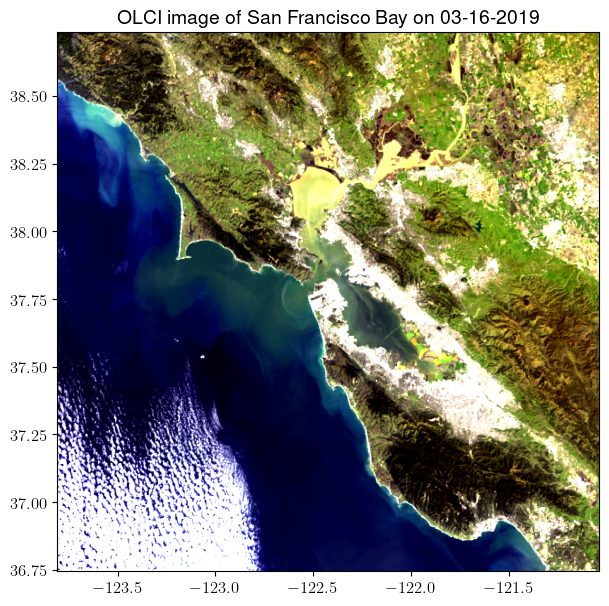

In [4]:
img_rgb = display_sat_rgb(tile_path, sensor, figsize=(7,7), title=f"{sensor} image of {location} on {date}", ipython_mode=True)

<b><font size="+1" color="red">Section 3: Atmospheric correction and other ancilliary data processing.</font></b>

The L1 datacubes for the satellite images for the OLCI, OCI and HICO satelites were downloaded from the <a href="https://oceancolor.gsfc.nasa.gov/about/missions/" style="color:blue">NASA oceancolor website</a>. Similarly the MSI L1 cubes were obtained from the <a href="https://browser.dataspace.copernicus.eu/" style="color:blue">Copernicus Data Browser</a>. The data available for this tutorial is processed using the <a href="https://github.com/acolite/acolite/" style="color:blue">ACOLITE</a>, which is an atmospehric correction algorithm that is applicable to a wide variety of sensors and is designed for aquatic ecosystems including eutrophic coastal and inland waters. In this case, we chose ACOLITE as our AC processor as it is applicable across all the sensors under consideration in this tutorial. The ACOLITE AC processor is run with it's default settings. It is worth noting that the Rrs data available from ACOLITE has had all land pixels masked out, as demonstrated below.


Text(0.5, 1.0, 'The Rrs of the bands corresponding to 412 nm')

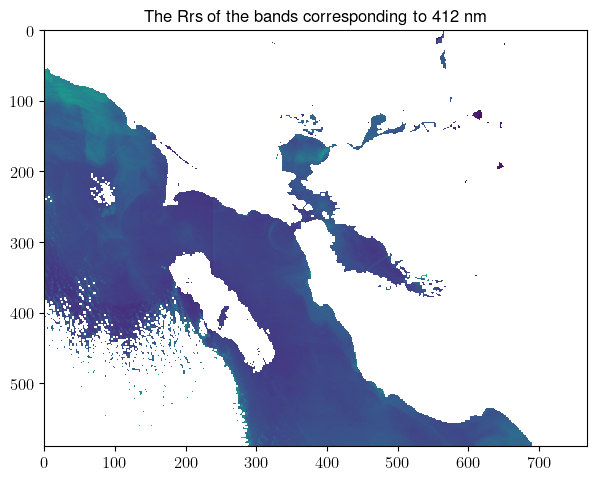

In [5]:
'Let us now load the Rrs data'
bands, Rrs =  get_tile_data(tile_path, sensor)
'Get the geographic information'
lon, lat, extent = get_tile_geographic_info(tile_path)

'Display the results'
fig1, ax1 = plt.subplots(figsize=(7,7))
fig1.patch.set_visible(True)

img1 = ax1.imshow(np.squeeze(Rrs[:, :, 0]))
ax1.set_title(f'The Rrs of the bands corresponding to {bands[0]} nm')

Note that all the land pixels have been masked out. Further note that even in the open ocean some pixels have been masked out due to other environmental nuisance factors including clouds, specular reflectance, and land contribution. Thus we have identified a set high quality pixels with clear water presence for which we can use the MDNs to estimate the BPs and IOPs.

<b><font size="+1" color="red">Section 4: Generating predictions from the MDN using the masked cube.</font></b>

The package provides the function <a style="font-family:'Courier New'">map_cube</a> which can be used to map the image cubes. The function assumes that the first input is a 3d numpy matrix contain the actual land-masked satellite Rrs cube, the second input is a list holding the bands corresponding to the spectral bands in the Rrs cube. Then the <a style="font-family:'Courier New'">sensor</a> and <a style="font-family:'Courier New'">products</a> variables are needed to select the appropriate pretrained model from the ones available to the package.

By default, the outputs are the MDN predictions and slices, The MDN predictions are also arranged as 3D cubes in the variable <a style="font-family:'Courier New'">maps</a>. The other output variable <a style="font-family:'Courier New'">slices</a> just contains the slice information corresponding to each of the output products produced by the pretrained MDN model.

In [6]:
'Run MDNs on Rrs to create a product object for image mapping'
maps, slices = map_cube(np.asarray(Rrs), bands, sensor, products)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]


Let us now visalize the spatial trends in the model's predictions for the scenarios mentioned here. For visualization use the <a style="font-family:'Courier New'">overlay_rgb_mdnProducts</a> function provided as part of the package. This function places the mdn generated product maps over an rgb background. In this case, let us use the RGB visulazation of the scene as the background, the function automatically masks out the land/cloud pixels in the generated products to enable easy visulazation of the spatial trends in the water bodies under consideration.

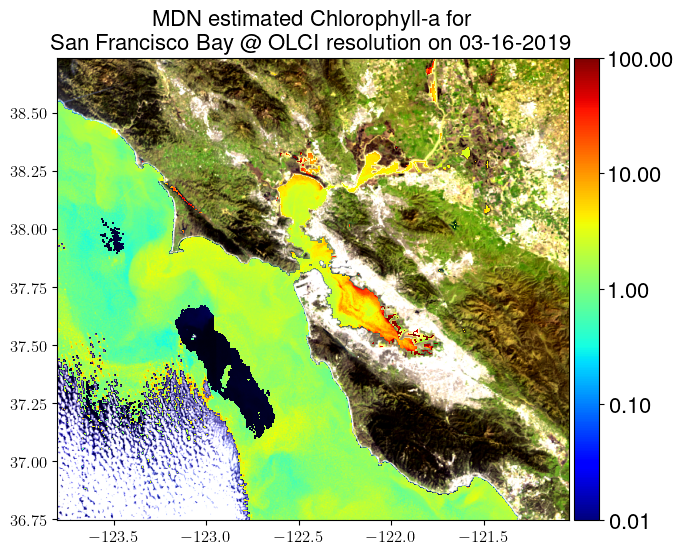

In [7]:
str1 = f"MDN estimated Chlorophyll-a for \n {location} @ {sensor} resolution on {date}"
fig = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['chl']], extent,
                              product_name=str1, pred_ticks= [-2, -1, 0, 1, 2], figsize=(7, 6))

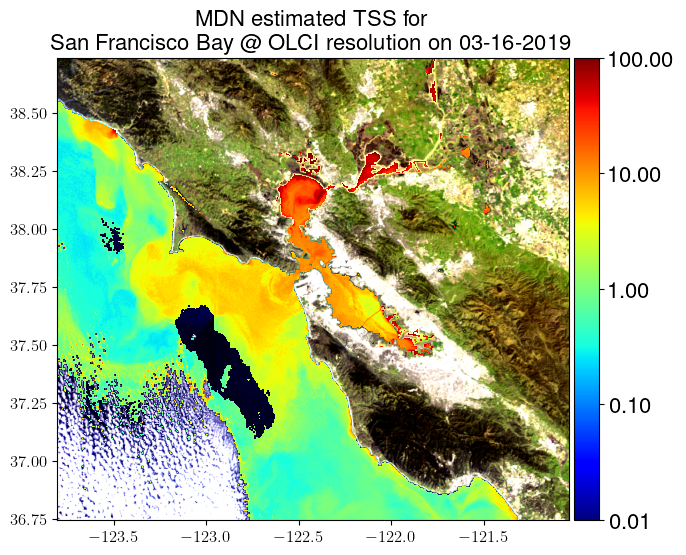

In [8]:
str1 = f"MDN estimated TSS for \n {location} @ {sensor} resolution on {date}"
fig = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['tss']], extent,
                              product_name=str1, pred_ticks= [-2, -1, 0, 1, 2], figsize=(7, 6))

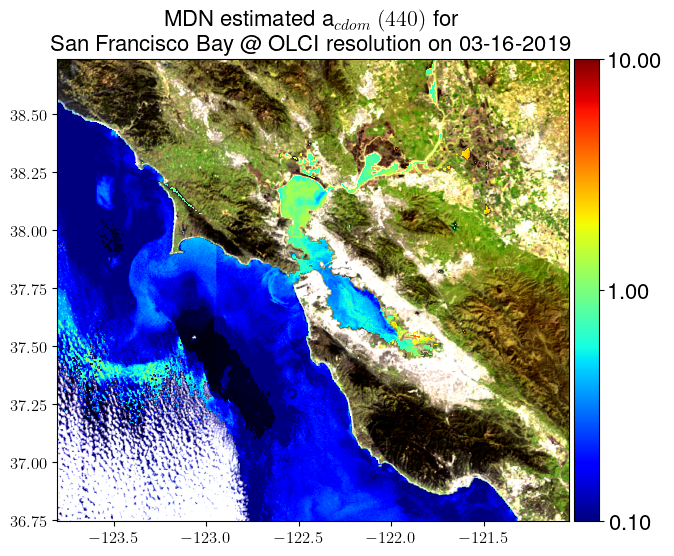

In [9]:
str1 = r"MDN estimated a$_{cdom}~(440)$ " + f"for \n {location} @ {sensor} resolution on {date}"
fig = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['cdom']], extent,
                              product_name=str1, pred_ticks= [-1, 0, 1], figsize=(7, 6))

<b><font size="+1" color="red">Section 5: Simultaneous extraction and visulazation of the uncertainty estimates.</font></b>

In case the user wants to simultaneously extract the measures of the model predictive uncertainty described in this [notebook](SC_3_MDN_product_uncertainty.ipynb), the <a style="font-family:'Courier New'">map_cube</a> function can also be used to simultaneous return the model uncertainty estimates. This behavior is controlled by the <a style="font-family:'Courier New'">flg_uncert</a> parameter. By default, this variable is set to <a style="font-family:'Courier New'">False</a>, but if you want to extract the uncertainties simply set this value to <a style="font-family:'Courier New'">True</a>. Another parameter to consider is <a style="font-family:'Courier New'">scaler_mode</a>, this controls whether the estimated uncertainties are scaled back into the physical parameter space.

One behavioral aspect to note is that when the variable <a style="font-family:'Courier New'">flg_uncert</a> is set to <a style="font-family:'Courier New'">True</a>, the uncertainty appears as the second output of the function. Further, this operation is a little slower as we have sequentially estimate model uncertainties. In future releases, we will work on speeding up the uncertainty estimation by leveraging packages like <a style="font-family:'Courier New'">numba</a>, enabling parallel estimation of these values.

In [10]:
'Simultaneously generate uncertainty maps'
maps, uncert, slices = map_cube(np.asarray(Rrs), bands, sensor, products, flg_uncert=True, scaler_mode="invert")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.91it/s]


Again for visualization the <a style="font-family:'Courier New'">overlay_rgb_mdnProducts</a> function can be used. The uncertainty corresponding to the specific variable should also be provided to the visualization function using the parameter <a style="font-family:'Courier New'">img_uncert</a>.  </br>

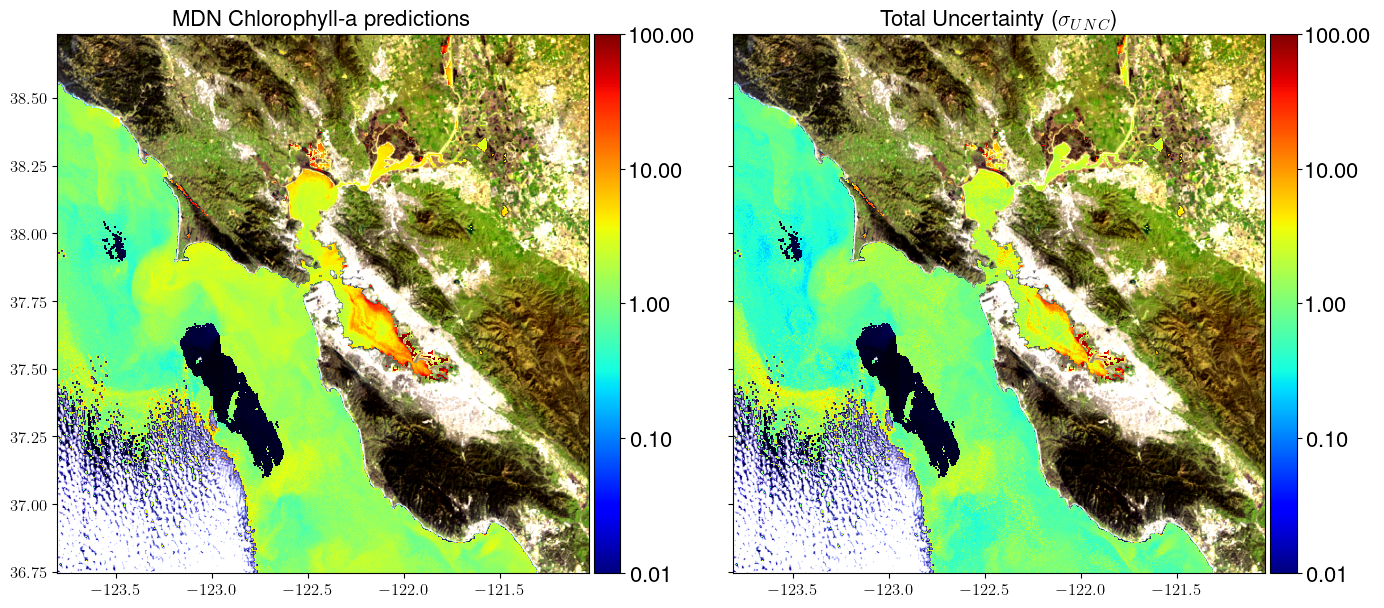

In [11]:
str1 = f"MDN Chlorophyll-a predictions"
figu = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['chl']], extent, img_uncert= uncert[:,:, slices['chl']],
                              product_name=str1, pred_ticks= [-2, -1, 0, 1, 2], pred_uncert_ticks = [-2, -1, 0, 1, 2], figsize=(16, 7))

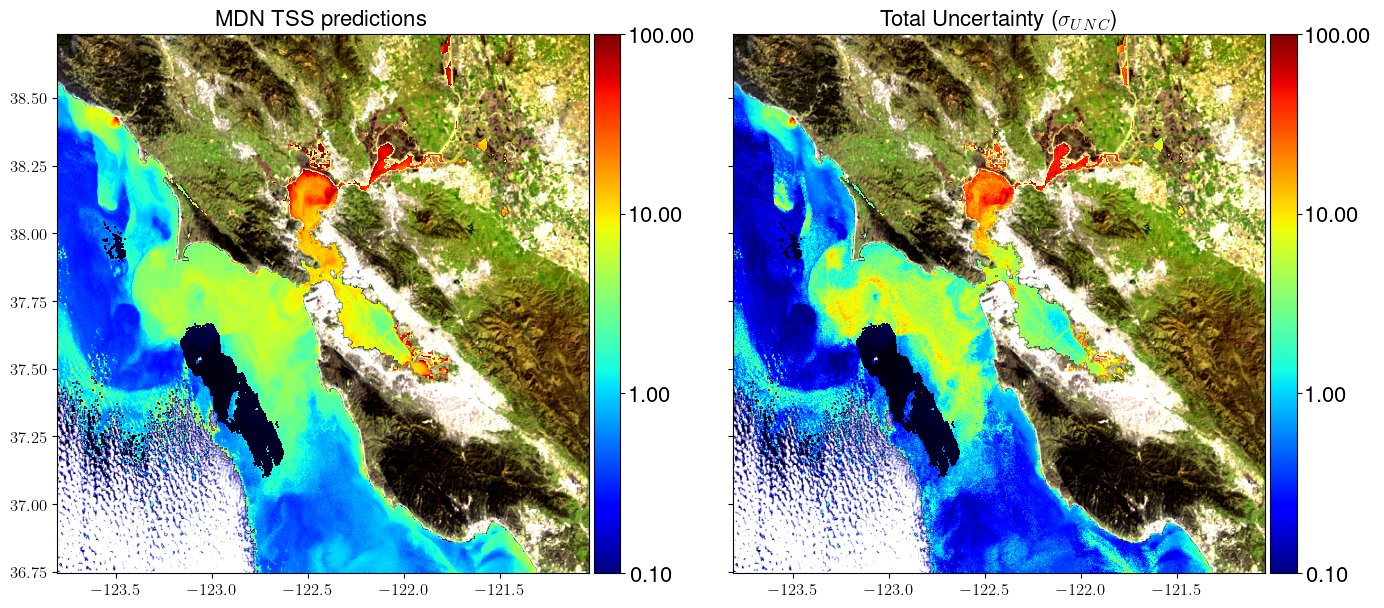

In [12]:
str1 = f"MDN TSS predictions"
figu = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['tss']], extent, img_uncert= uncert[:,:, slices['tss']],
                              product_name=str1, pred_ticks= [-1, 0, 1, 2], pred_uncert_ticks = [-1, 0, 1, 2], figsize=(16, 7))

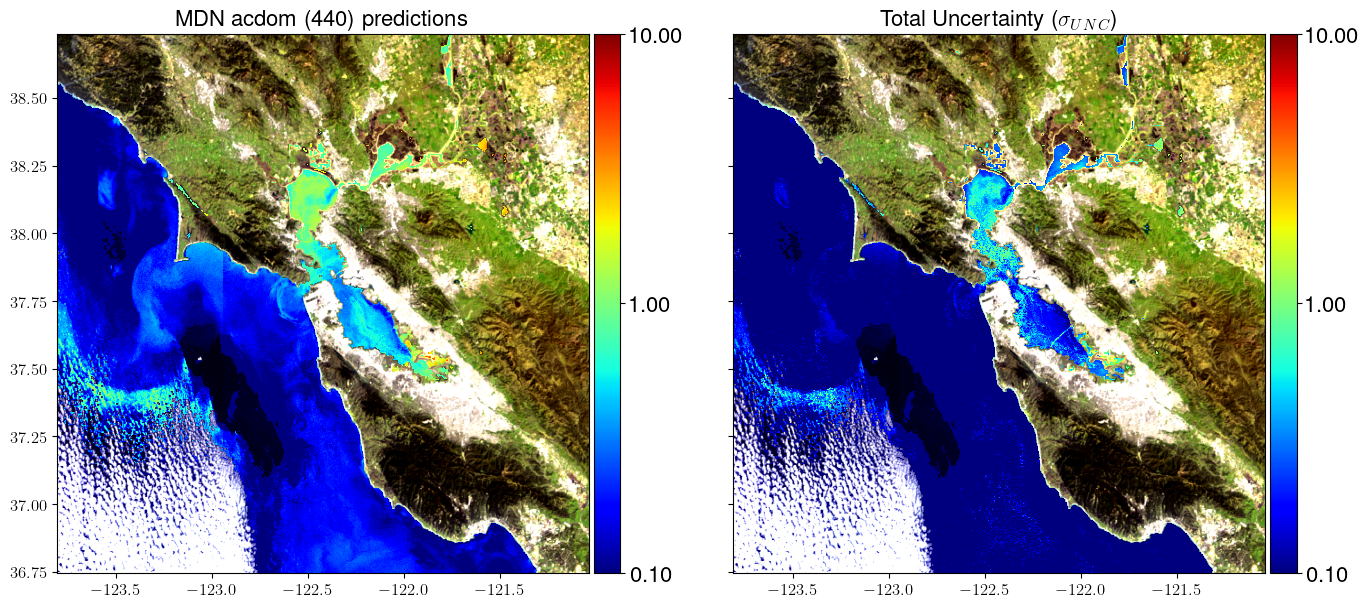

In [13]:
str1 = f"MDN acdom (440) predictions"
figu = overlay_rgb_mdnProducts(img_rgb, maps[:,:, slices['cdom']], extent, img_uncert= uncert[:,:, slices['cdom']],
                              product_name=str1, pred_ticks= [-1, 0, 1,], pred_uncert_ticks = [-1, 0, 1], figsize=(16, 7))